# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

639

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
# set up base url, count, and empty lists
from multiprocessing.context import assert_spawning


url = "http://api.openweathermap.org/data/2.5/weather?"
city_count = 0
city_names = []
lat_ls = []
lng_ls = []
max_temp_ls = []
humidity_ls = []
cloudiness_ls = []
wind_spd_ls = []
country_ls = []
date_ls = []

print("Begining Data Retrieval")
print("-----------------------")
# loop through every city in the cities list
for city in cities:
    # build query url and retreive json data
    query_url = url + "appid=" + weather_api_key + "&q=" + city + "&units=imperial"
    weather_json = requests.get(query_url).json()
    # attempt to get weather information of the city, skip in case the city is not in weather database
    try:
        print(f"Processing Record {city_count} | {weather_json['name']}")
        # add weather information to lists
        city_names.append(weather_json['name'])
        lat_ls.append(weather_json['coord']['lat'])
        lng_ls.append(weather_json['coord']['lon'])
        max_temp_ls.append(weather_json['main']['temp_max'])
        humidity_ls.append(weather_json['main']['humidity'])
        cloudiness_ls.append(weather_json['clouds']['all'])
        wind_spd_ls.append(weather_json['wind']['speed'])
        country_ls.append(weather_json['sys']['country'])
        date_ls.append(weather_json['dt'])
        city_count += 1
    except Exception as e:
        print("City not found. Skipping ...")


Begining Data Retrieval
-----------------------
Processing Record 0 | Ancud
Processing Record 1 | Jamestown
Processing Record 2 | Kutulik
Processing Record 3 | Vao
City not found. Skipping ...
Processing Record 4 | Yeppoon
Processing Record 5 | Coromandel
Processing Record 6 | Albany
Processing Record 7 | Yerofey Pavlovich
Processing Record 8 | Bluff
Processing Record 9 | Busselton
Processing Record 10 | Cherskiy
Processing Record 11 | Hobart
Processing Record 12 | Port Alfred
Processing Record 13 | Rikitea
Processing Record 14 | San Policarpo
Processing Record 15 | Hermanus
Processing Record 16 | Ponta do Sol
Processing Record 17 | Ushuaia
Processing Record 18 | Codrington
City not found. Skipping ...
Processing Record 19 | Tasiilaq
Processing Record 20 | Boissevain
Processing Record 21 | Punta Arenas
Processing Record 22 | Palmer
Processing Record 23 | Atuona
Processing Record 24 | Igarka
Processing Record 25 | Oranjemund
Processing Record 26 | Naze
Processing Record 27 | New Norfolk

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [4]:
data_dict = {
    "City": city_names,
    "Latitude":lat_ls,
    "Longitude":lng_ls,
    "Max Temp": max_temp_ls,
    "Humidity":humidity_ls,
    "Cloudiness": cloudiness_ls,
    "Wind Speed":wind_spd_ls,
    "Country": country_ls,
    "Date": date_ls
    }
weather_df = pd.DataFrame(data_dict)
weather_df.to_csv('../output/cities.csv')
weather_df.head()

,City,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Ancud,-41.8697,-73.8203,42.22,75,13,4.59,CL,1660779196
1,Jamestown,42.0970,-79.2353,71.19,82,0,0.00,US,1660778816
2,Kutulik,53.3508,102.7839,50.14,80,99,1.52,RU,1660779197
3,Vao,-22.6667,167.4833,61.95,90,100,17.45,NC,1660779198
4,Yeppoon,-23.1333,150.7333,60.58,45,0,0.98,AU,1660779198


In [5]:
weather_df.describe()

,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,5.850000e+02
mean,22.662512,19.438224,68.259846,72.570940,53.241026,7.886410,1.660779e+09
std,33.169911,88.498792,13.861879,19.130737,37.693860,5.352384,1.020985e+02
min,-54.800000,-175.200000,32.050000,13.000000,0.000000,0.000000,1.660779e+09
25%,-3.383600,-59.516700,59.180000,62.000000,17.000000,3.830000,1.660779e+09
50%,30.079900,27.466700,70.290000,77.000000,56.000000,6.550000,1.660779e+09
75%,49.230600,95.321400,78.800000,87.000000,94.000000,10.670000,1.660779e+09
max,78.218600,179.316700,104.290000,100.000000,100.000000,31.230000,1.660779e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [6]:
#  Get the indices of cities that have humidity over 100%.
hum_ovr_100 = weather_df.index[weather_df['Humidity']>100]
hum_ovr_100


Int64Index([], dtype='int64')

In [7]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = weather_df.drop(index=hum_ovr_100)
clean_city_data.head()

,City,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Ancud,-41.8697,-73.8203,42.22,75,13,4.59,CL,1660779196
1,Jamestown,42.0970,-79.2353,71.19,82,0,0.00,US,1660778816
2,Kutulik,53.3508,102.7839,50.14,80,99,1.52,RU,1660779197
3,Vao,-22.6667,167.4833,61.95,90,100,17.45,NC,1660779198
4,Yeppoon,-23.1333,150.7333,60.58,45,0,0.98,AU,1660779198


In [21]:
clean_city_data.describe()

,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,5.850000e+02
mean,22.662512,19.438224,68.259846,72.570940,53.241026,7.886410,1.660779e+09
std,33.169911,88.498792,13.861879,19.130737,37.693860,5.352384,1.020985e+02
min,-54.800000,-175.200000,32.050000,13.000000,0.000000,0.000000,1.660779e+09
25%,-3.383600,-59.516700,59.180000,62.000000,17.000000,3.830000,1.660779e+09
50%,30.079900,27.466700,70.290000,77.000000,56.000000,6.550000,1.660779e+09
75%,49.230600,95.321400,78.800000,87.000000,94.000000,10.670000,1.660779e+09
max,78.218600,179.316700,104.290000,100.000000,100.000000,31.230000,1.660779e+09


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

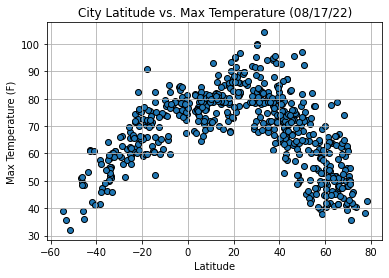

In [8]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.scatter(clean_city_data['Latitude'], clean_city_data['Max Temp'], edgecolors="black")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.title("City Latitude vs. Max Temperature (08/17/22)")
plt.grid()
plt.savefig('../output/lat_vs_temp.png')

## Latitude vs. Humidity Plot

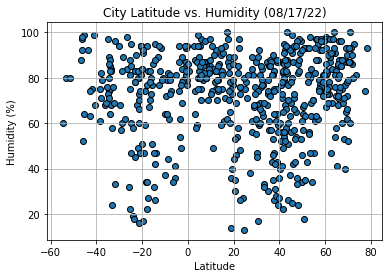

In [9]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.scatter(clean_city_data['Latitude'], clean_city_data['Humidity'], edgecolors="black")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title("City Latitude vs. Humidity (08/17/22)")
plt.grid()

plt.savefig('../output/lat_vs_humidity.png')

## Latitude vs. Cloudiness Plot

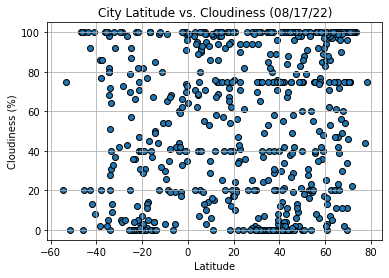

In [10]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.scatter(clean_city_data['Latitude'], clean_city_data['Cloudiness'], edgecolors="black")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title("City Latitude vs. Cloudiness (08/17/22)")
plt.grid()
plt.savefig('../output/lat_vs_cloudiness.png')

## Latitude vs. Wind Speed Plot

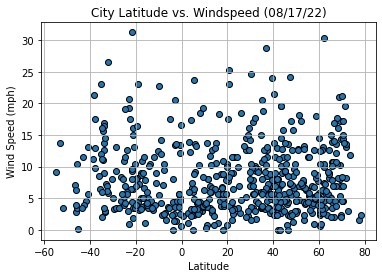

In [11]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.scatter(clean_city_data['Latitude'], clean_city_data['Wind Speed'], edgecolors="black")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title("City Latitude vs. Windspeed (08/17/22)")
plt.grid()
plt.savefig('../output/lat_vs_WindSpd.png')

## Linear Regression

In [12]:
north_hemi_df = clean_city_data.loc[clean_city_data['Latitude']>=0,:]
south_hemi_df = clean_city_data.loc[clean_city_data['Latitude']<0,:]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.4895841154439652


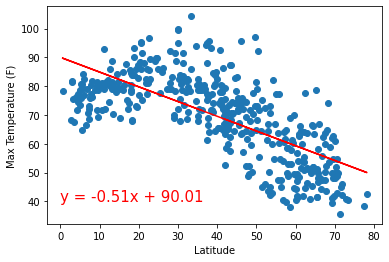

In [13]:
x_values = north_hemi_df['Latitude']
y_values = north_hemi_df['Max Temp']
plt.scatter(x_values, y_values)
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,40),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")


####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.6938411180917105


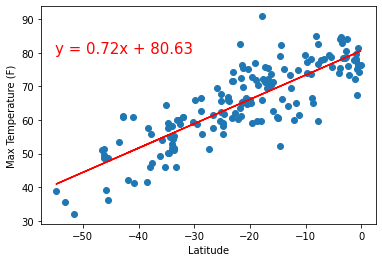

In [14]:
x_values = south_hemi_df['Latitude']
y_values = south_hemi_df['Max Temp']
plt.scatter(x_values, y_values)
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-55,80),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.00202506952916921


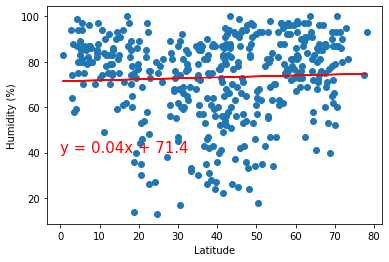

In [15]:
x_values = north_hemi_df['Latitude']
y_values = north_hemi_df['Humidity']
plt.scatter(x_values, y_values)
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,40),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.002457926714611571


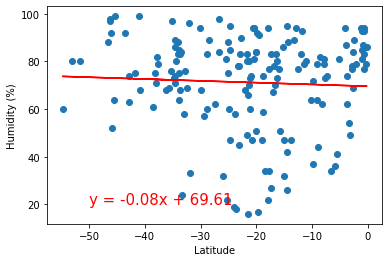

In [16]:
x_values = south_hemi_df['Latitude']
y_values = south_hemi_df['Humidity']
plt.scatter(x_values, y_values)
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,20),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.0021418865813851336


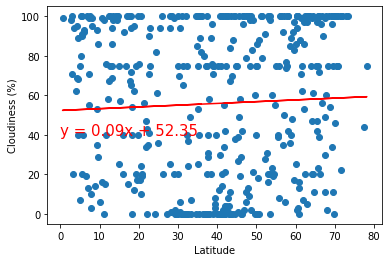

In [17]:
x_values = north_hemi_df['Latitude']
y_values = north_hemi_df['Cloudiness']
plt.scatter(x_values, y_values)
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,40),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.0021521623889238306


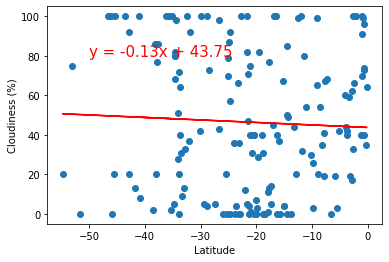

In [18]:
x_values = south_hemi_df['Latitude']
y_values = south_hemi_df['Cloudiness']
plt.scatter(x_values, y_values)
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,80),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.006737697039686705


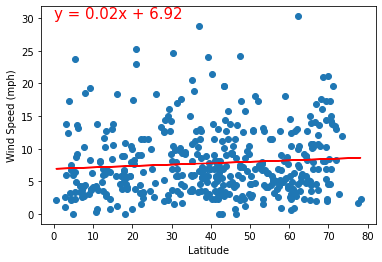

In [19]:
x_values = north_hemi_df['Latitude']
y_values = north_hemi_df['Wind Speed']
plt.scatter(x_values, y_values)
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,30),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.01881937111162719


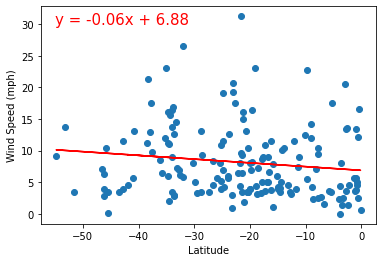

In [20]:
x_values = south_hemi_df['Latitude']
y_values = south_hemi_df['Wind Speed']
plt.scatter(x_values, y_values)
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-55,30),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")